## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)) <font size='3ptx'><b>Deep learning neural networks are trained using the stochastic gradient descent optimization algorithm.</b></font>

<b>The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated</b>. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

The learning rate may be the most important hyperparameter when configuring your neural network. Therefore <b>it is vital to know how to investigate the effects of the learning rate on model performance and to build an intuition about the dynamics of the learning rate on model behavior</b>.

In this tutorial, you will discover the effects of the learning rate, learning rate schedules, and adaptive learning rates on model performance.

After completing this tutorial, you will know:
* How large learning rates result in unstable training and tiny rates result in a failure to train.
* Momentum can accelerate training and learning rate schedules can help to converge the optimization process.
* Adaptive learning rates can accelerate training and alleviate some of the pressure of choosing a learning rate and learning rate schedule.

<a id='sect0'></a>
### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into six parts; they are:
* <font size='3ptx'><b><a href='#sect1'>Learning Rate and Gradient Descent</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Configure the Learning Rate in Keras</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>Multi-Class Classification Problem</a></b></font>
* <font size='3ptx'><b><a href='#sect4'>Effect of Learning Rate and Momentum</a></b></font>
* <font size='3ptx'><b><a href='#sect5'>Effect of Learning Rate Schedules</a></b></font>
* <font size='3ptx'><b><a href='#sect6'>Effect of Adaptive Learning Rates</a></b></font>

### <font color='darkgreen'>Import Necessary Modules</font>

In [32]:
# study of learning rate on accuracy for blobs problem
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras import backend
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

<a id='sect1'></a>
## <font color='darkblue'>Learning Rate and Gradient Descent</font>
<font size='3ptx'><b>Deep learning neural networks are trained using the stochastic gradient descent algorithm.</b></font>

<b>Stochastic gradient descent is an optimization algorithm that estimates the error gradient</b> for the current state of the model using examples from the training dataset, then updates the weights of the model using the [**back-propagation of errors algorithm**](https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/), referred to as simply <font color='darkblue'><b>backpropagation</b></font>.

<b>The amount that the weights are updated during training is referred to as the step size or the “<font color='darkblue'>learning rate</font>.”</b>

Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0.

<b>The learning rate controls how quickly the model is adapted to the problem</b>. Smaller learning rates require more [**training epochs**](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/) given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

<font color='darkred'><b>A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.</b></font>

The challenge of training deep learning neural networks involves carefully selecting the learning rate. It may be the most important hyperparameter for the model.
> The learning rate is perhaps the most important hyperparameter. If you have time to tune only one hyperparameter, tune the learning rate. <br/><br/>
> [**— Page 429, Deep Learning, 2016.**](https://amzn.to/2NJW3gE)

<br/>

Now that we are familiar with what the learning rate is, let’s look at how we can configure the learning rate for neural networks. For more on what the learning rate is and how it works, see the post:
* [How to Configure the Learning Rate Hyperparameter When Training Deep Learning Neural Networks](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/)

<a id='sect2'></a>
## <font color='darkblue'>Configure the Learning Rate in Keras</font>
<font size='3ptx'><b>The Keras deep learning library allows you to easily configure the learning rate for a number of different variations of the stochastic gradient descent optimization algorithm.</b></font>

### <font color='darkgreen'>Stochastic Gradient Descent</font>
<b>[Keras](https://www.tensorflow.org/api_docs/python/tf/keras) provides the [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) class that implements the stochastic gradient descent optimizer with a <font color='darkblue'>learning rate</font> and <font color='darkblue'>momentum</font>.</b>

First, an instance of the class must be created and configured, then specified to the “optimizer” argument when calling the <font color='blue'>fit()</font> function on the model. The default learning rate is 0.01 and no momentum is used by default.:

```python
from keras.optimizers import SGD
...
opt = SGD()
model.compile(..., optimizer=opt)
```
<br/>

The learning rate can be specified via the “<font color='violet'>lr</font>” argument and the momentum can be specified via the “<font color='violet'>momentum</font>” argument.
```python
from keras.optimizers import SGD
...
opt = SGD(lr=0.01, momentum=0.9)
model.compile(..., optimizer=opt)
```
<br/>

The class also supports learning rate decay via the “<font color='violet'>decay</font>” argument. With learning rate decay, the learning rate is calculated each update (<font color='brown'>e.g. end of each mini-batch</font>) as follows:
```python
lrate = initial_lrate * (1 / (1 + decay * iteration))
```
<br/>

Where `lrate` is the learning rate for the current epoch, `initial_lrate` is the learning rate specified as an argument to [**SGD**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD), `decay` is the decay rate which is greater than zero and iteration is the current update number.
```python
from keras.optimizers import SGD
...
opt = SGD(lr=0.01, momentum=0.9, decay=0.01)
model.compile(..., optimizer=opt)
```

### <font color='darkgreen'>Learning Rate Schedule</font>
<b>Keras supports learning rate schedules via callbacks.</b>

The callbacks operate separately from the optimization algorithm, although they adjust the learning rate used by the optimization algorithm. It is recommended to use the SGD when using a learning rate schedule callback.

Callbacks are instantiated and configured, then specified in a list to the “<font color='violet'>callbacks</font>” argument of the <font color='blue'>fit()</font> function when training the model.

Keras provides the [**ReduceLROnPlateau**](https://keras.io/callbacks/#reducelronplateau) that will adjust the learning rate when a plateau in model performance is detected, e.g. no change for a given number of training epochs. <b>This callback is designed to reduce the learning rate after the model stops improving with the hope of fine-tuning model weights</b>.

The [**ReduceLROnPlateau**](https://keras.io/callbacks/#reducelronplateau) requires you to specify the metric to monitor during training via the “<font color='violet'>monitor</font>” argument, the value that the learning rate will be multiplied by via the “<font color='violet'>factor</font>” argument and the “<font color='violet'>patience</font>” argument that specifies the number of training epochs to wait before triggering the change in learning rate.

For example, we can monitor the validation loss and reduce the learning rate by an order of magnitude if validation loss does not improve for 100 epochs:

```python
# snippet of using the ReduceLROnPlateau callback
from keras.callbacks import ReduceLROnPlateau
...
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
model.fit(..., callbacks=[rlrop])
```
<br/>

Keras also provides [**LearningRateScheduler**](https://keras.io/callbacks/#learningratescheduler) callback that allows you to specify a function that is called each epoch in order to adjust the learning rate. You can define your Python function that takes two arguments (<font color='brown'>epoch and current learning rate</font>) and returns the new learning rate:
```python
# snippet of using the LearningRateScheduler callback
from keras.callbacks import LearningRateScheduler
...

def my_learning_rate(epoch, lrate):
	return lrate

lrs = LearningRateScheduler(my_learning_rate)
model.fit(..., callbacks=[lrs])
```

<a id='sect2_3'></a>
### <font color='darkgreen'>Adaptive Learning Rate Gradient Descent</font>
<b>Keras also provides a suite of extensions of simple stochastic gradient descent that support adaptive learning rates.</b>

Because each method adapts the learning rate, often one learning rate per model weight, little configuration is often required.

Three commonly used adaptive learning rate methods include:
* [**RMSProp Optimizer**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop)
```python
from keras.optimizers import RMSprop
...
opt = RMSprop()
model.compile(..., optimizer=opt)
```

* [**Adagrad Optimizer**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad)
```python
from keras.optimizers import Adagrad
...
opt = Adagrad()
model.compile(..., optimizer=opt)
```
* [**Adam Optimizer**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
```python
from keras.optimizers import Adam
...
opt = Adam()
model.compile(..., optimizer=opt)
```

<a id='sect3'></a>
## <font color='darkblue'>Multi-Class Classification Problem</font>
<font size='3ptx'><b>We will use a small multi-class classification problem as the basis to demonstrate the effect of learning rate on model performance.</b></font>

The scikit-learn class provides the <b>[make_blobs()](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function that can be used to create a multi-class classification problem with the prescribed number of samples, input variables, classes, and variance of samples within a class</b>.

The problem has two input variables (<font color='brown'>to represent the `x` and `y` coordinates of the points</font>) and a standard deviation of 2.0 for points within each group. We will use the same random state (<font color='brown'>seed for the pseudorandom number generator</font>) to ensure that we always get the same data points:
```python
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
```
<br/>

The results are the input and output elements of a dataset that we can model.

In order to get a feeling for the complexity of the problem, we can plot each point on a two-dimensional scatter plot and color each point by class value.

The complete example is listed below.

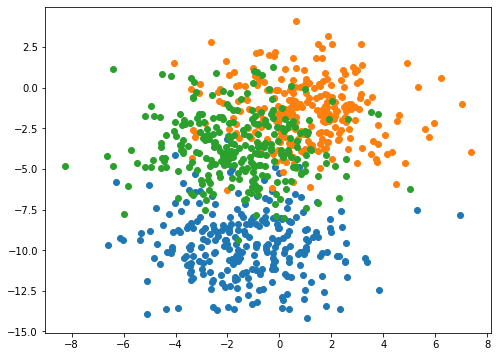

In [16]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

pyplot.rcParams['figure.figsize'] = [8, 6]

# generate 2d classification dataset
X, y = make_blobs(n_samples=800, centers=3, n_features=2, cluster_std=2, random_state=2)

# scatter plot for each class value
for class_value in range(3):
    # select indices of points with the class label
    row_ix = where(y == class_value)
    # scatter plot for points with a different color
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1])

# show plot
pyplot.show()

Running the example creates a scatter plot of the entire dataset. We can see that the standard deviation of 2.0 means that the classes are not linearly separable (<font color='brown'>separable by a line</font>), causing many ambiguous points.

This is desirable as it means that the problem is non-trivial and will allow a neural network model to find many different “good enough” candidate solutions.

<a id='sect4'></a>
## <font color='darkblue'>Effect of Learning Rate and Momentum</font>
* <font size='3ptx'><b><a href='#sect4_1'>Learning Rate Dynamics</a></b></font>
* <font size='3ptx'><b><a href='#sect4_2'>Momentum Dynamics</a></b></font>

<font size='3ptx'><b>In this section, we will develop a Multilayer Perceptron (<font color='brown'>MLP</font>) model to address the blobs classification problem and investigate the effect of different learning rates and momentum.</b></font>

<a id='sect4_1'></a>
### <font color='darkgreen'>Learning Rate Dynamics</font>
**The first step is to develop a function that will create the samples from the problem and split them into train and test datasets.**

Additionally, we must also one hot encode the target variable so that we can develop a model that predicts the probability of an example belonging to each class.

The <font color='blue'>prepare_data()</font> function below implements this behavior, returning train and test sets split into input and output elements.

In [17]:
# prepare train and test dataset
def prepare_data(n_samples=1000):
    # generate 2d classification dataset
    X, y = make_blobs(n_samples=n_samples, centers=3, n_features=2, cluster_std=2, random_state=2)

    # one hot encode output variable
    y = to_categorical(y)

    # split into train and test
    n_train = int(n_samples * 0.7)
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy

Next, we can develop a function to fit and evaluate an MLP model.

First, we will define a simple MLP model that expects two input variables from the blobs problem, has a single hidden layer with 50 nodes, and an output layer with three nodes to predict the probability for each of the three classes. Nodes in the hidden layer will use the <b><a href='https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/'>rectified linear activation function</a></b> (<font color='brown'>ReLU</font>), whereas nodes in the output layer will use the softmax activation function.

In [4]:
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))

2022-02-19 08:00:06.193489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-19 08:00:06.193535: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-19 08:00:06.193568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-02-19 08:00:06.193854: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We will use the stochastic gradient descent optimizer and require that the learning rate be specified so that we can evaluate different rates. The model will be trained to minimize cross entropy.
```python
# compile model
opt = SGD(lr=lrate)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
```
<br/>

The model will be fit for 200 training epochs, found with a little trial and error, and the test set will be used as the validation dataset so we can get an idea of the generalization error of the model during training.
```python
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
```
<br/>

The <font color='blue'>fit_model()</font> function below ties together these elements and will fit a model and plot its performance given the train and test datasets as well as a specific learning rate to evaluate.

In [5]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, lrate):
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    opt = SGD(lr=lrate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('lrate='+str(lrate), pad=-50)

Running the example creates a single figure that contains eight line plots for the eight different evaluated learning rates. Classification accuracy on the training dataset is marked in blue, whereas accuracy on the test dataset is marked in orange.

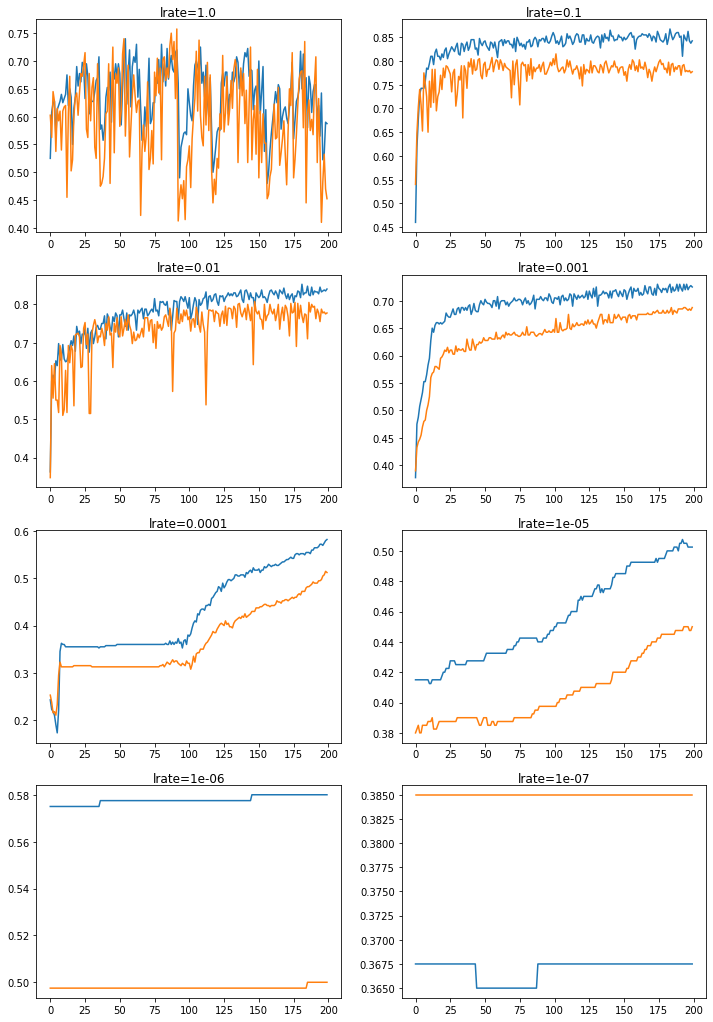

In [10]:
pyplot.rcParams['figure.figsize'] = [12, 18]
# prepare dataset
trainX, trainy, testX, testy = prepare_data(800)
# create learning curves for different learning rates
learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
for i in range(len(learning_rates)):
    # determine the plot number
    plot_no = 420 + (i+1)
    pyplot.subplot(plot_no)
    # fit model and plot learning curves for a learning rate
    fit_model(trainX, trainy, testX, testy, learning_rates[i])

# show learning curves
pyplot.show()

**The plots show oscillations in behavior for the too-large learning rate of 1.0 and the inability of the model to learn anything with the too-small learning rates of 1E-6 and 1E-7**

We can see that the model was able to learn the problem well with the learning rates 1E-1, 1E-2 and 1E-3, although successively slower as the learning rate was decreased. **With the chosen model configuration, <font color='green'>the results suggest a moderate learning rate of 0.1 results in good model performance on the train and test sets</font>.**

<a id='sect4_2'></a>
### <font color='darkgreen'>Momentum Dynamics</font>
**Momentum can smooth the progression of the learning algorithm that, in turn, can accelerate the training process.**

We can adapt the example from the previous section to evaluate the effect of momentum with a fixed learning rate. In this case, we will choose the learning rate of 0.01 that in the previous section converged to a reasonable solution, but required more epochs than the learning rate of 0.1

The <font color='blue'>fit_model()</font> function can be updated to take a “<font color='violet'>momentum</font>” argument instead of a learning rate argument, that can be used in the configuration of the SGD class and reported on the resulting plot.

The updated version of this function is listed below.

In [11]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, momentum):
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    opt = SGD(lr=0.01, momentum=momentum)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
    
    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('momentum='+str(momentum), pad=-80)

**It is common to use momentum values close to 1.0, such as 0.9 and 0.99.**

In this example, we will demonstrate the dynamics of the model without momentum compared to the model with momentum values of 0.5 and the higher momentum values.

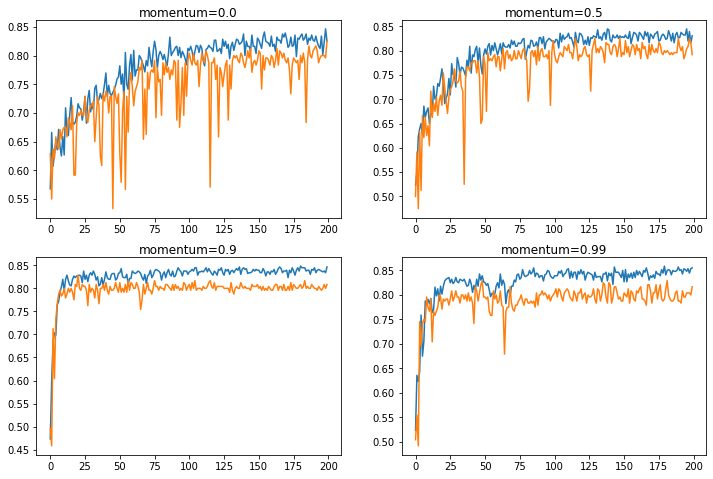

In [19]:
pyplot.rcParams['figure.figsize'] = [12, 8]

# prepare dataset
trainX, trainy, testX, testy = prepare_data(800)

# create learning curves for different momentums
momentums = [0.0, 0.5, 0.9, 0.99]
for i in range(len(momentums)):    
    # determine the plot number
    plot_no = 220 + (i+1)
    pyplot.subplot(plot_no)
    
    # fit model and plot learning curves for a momentum
    fit_model(trainX, trainy, testX, testy, momentums[i])
    
# show learning curves
pyplot.show()

Running the example creates a single figure that contains four line plots for the different evaluated momentum values. Classification accuracy on the training dataset is marked in blue, whereas accuracy on the test dataset is marked in orange.

We can see that **the addition of momentum does accelerate the training of the model**. Specifically, momentum values of 0.9 and 0.99 achieve reasonable train and test accuracy within about 50 training epochs as opposed to 200 training epochs when momentum is not used.

<font color='green'>**In all cases where momentum is used, the accuracy of the model on the holdout test dataset appears to be more stable, showing less volatility over the training epochs**</font>.

<a id='sect5'></a>
## <font color='darkblue'>Effect of Learning Rate Schedules</font> ([back](#sect0))
* <b><font size='3ptx'><a href='#sect5_1'>Learning Rate Decay</a></font></b>
* <b><font size='3ptx'><a href='#sect5_2'>Drop Learning Rate on Plateau</a></font></b>
<br/>

<font size='3ptx'><b>We will look at two learning rate schedules in this section.</b></font>

The first is the decay built into the SGD class and the second is the [**ReduceLROnPlateau**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) callback.

<a id='sect5_1'></a>
### <font color='darkgreen'>Learning Rate Decay</font>
**The SGD class provides the “<font color='violet'>decay</font>” argument that specifies the learning rate decay.**

It may not be clear from the equation or the code as to the effect that this decay has on the learning rate over updates. We can make this clearer with a worked example. The function below implements the learning rate decay as implemented in the [**SGD**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) class:
```python
# learning rate decay
def decay_lrate(initial_lrate, decay, iteration):
	return initial_lrate * (1.0 / (1.0 + decay * iteration))
```
<br/>

We can use this function to calculate the learning rate over multiple updates with different decay values.

We will compare a range of decay values [1E-1, 1E-2, 1E-3, 1E-4] with an initial learning rate of 0.01 and 200 weight updates.

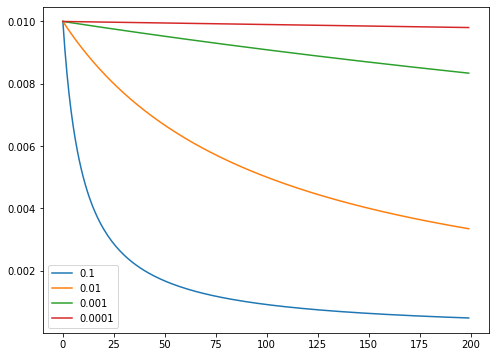

In [21]:
pyplot.rcParams['figure.figsize'] = [8, 6]

# learning rate decay
def	decay_lrate(initial_lrate, decay, iteration):
    return initial_lrate * (1.0 / (1.0 + decay * iteration))
 
decays = [1E-1, 1E-2, 1E-3, 1E-4]
lrate = 0.01
n_updates = 200
for decay in decays:
    # calculate learning rates for updates
    lrates = [decay_lrate(lrate, decay, i) for i in range(n_updates)]
    # plot result
    pyplot.plot(lrates, label=str(decay))

pyplot.legend()
pyplot.show()

Running the example creates a line plot showing learning rates over updates for different decay values.

We can see that in all cases, the learning rate starts at the initial value of 0.01. We can see that a small decay value of 1E-4 (<font color='brown'>red</font>) has almost no effect, whereas a large decay value of 1E-1 (<font color='brown'>blue</font>) has a dramatic effect, reducing the learning rate to below 0.002 within 50 epochs (<font color='brown'>about one order of magnitude less than the initial value</font>) and arriving at the final value of about 0.0004 (<font color='brown'>about two orders of magnitude less than the initial value</font>).

**We can see that the change to the learning rate is not linear. We can also see that changes to the learning rate are dependent on the batch size, after which an update is performed**. In the example from the previous section, a default batch size of 32 across 500 examples results in 16 updates per epoch and 3,200 updates across the 200 epochs.

Using a decay of 0.1 and an initial learning rate of 0.01, we can calculate the final learning rate to be a tiny value of about 3.1E-05.

We can update the example from the previous section to evaluate the dynamics of different learning rate decay values.

Fixing the learning rate at 0.01 and not using momentum, we would expect that a very small learning rate decay would be preferred, as a large learning rate decay would rapidly result in a learning rate that is too small for the model to learn effectively.

The updated version of the function is listed below.

In [22]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, decay):
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    opt = SGD(lr=0.01, decay=decay)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)

    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('decay='+str(decay), pad=-80)

We can evaluate the same four decay values of [1E-1, 1E-2, 1E-3, 1E-4] and their effect on model accuracy.

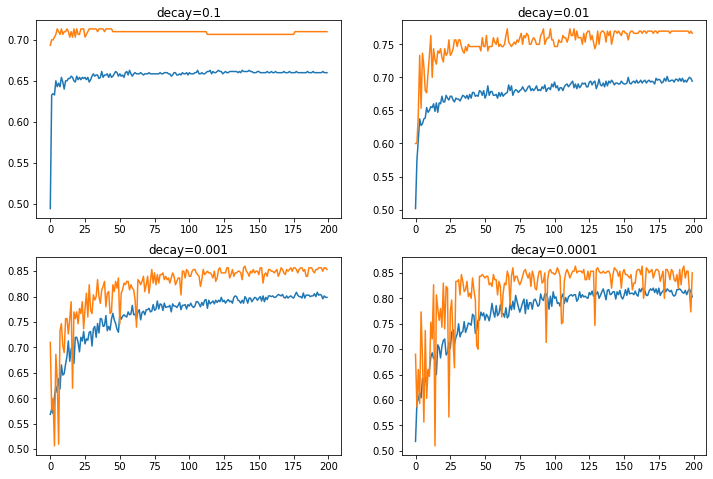

In [23]:
pyplot.rcParams['figure.figsize'] = [12, 8]

# prepare dataset
trainX, trainy, testX, testy = prepare_data()

# create learning curves for different decay rates
decay_rates = [1E-1, 1E-2, 1E-3, 1E-4]
for i in range(len(decay_rates)):
    # determine the plot number
    plot_no = 220 + (i+1)
    pyplot.subplot(plot_no)
    # fit model and plot learning curves for a decay rate
    fit_model(trainX, trainy, testX, testy, decay_rates[i])

# show learning curves
pyplot.show()

Running the example creates a single figure that contains four line plots for the different evaluated learning rate decay values. Classification accuracy on the training dataset is marked in blue, whereas accuracy on the test dataset is marked in orange.

We can see that the **<font color='darkred'>large decay values of 1E-1 and 1E-2 indeed decay the learning rate too rapidly for this model on this problem and result in poor performance</font>**. The smaller decay values do result in better performance, with the value of 1E-4 perhaps causing in a similar result as not using decay at all. In fact, we can calculate the final learning rate with a decay of 1E-4 to be about 0.0075, only a little bit smaller than the initial value of 0.01.

<a id='sect5_2'></a>
### <font color='darkgreen'>Drop Learning Rate on Plateau</font>
<b>The [ReduceLROnPlateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) will drop the learning rate by a factor after no change in a monitored metric for a given number of epochs.</b>

We can explore the effect of different “<font color='violet'>patience</font>” values, which is the number of epochs to wait for a change before dropping the learning rate. We will use the default learning rate of 0.01 and drop the learning rate by an order of magnitude by setting the “<font color='violet'>factor</font>” argument to 0.1:
```python
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, min_delta=1E-7)
```
<br/>

**It will be interesting to review the effect on the learning rate over the training epochs**. We can do that by creating a new Keras Callback that is responsible for recording the learning rate at the end of each training epoch. We can then retrieve the recorded learning rates and create a line plot to see how the learning rate was affected by drops.

We can create a custom [**Callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) called <font color='blue'><b>LearningRateMonitor</b></font>. The <font color='blue'>on_train_begin()</font> function is called at the start of training, and in it we can define an empty list of learning rates. The <font color='blue'>on_epoch_end()</font> function is called at the end of each training epoch and in it we can retrieve the optimizer and the current learning rate from the optimizer and store it in the list. The complete callback is listed below.

In [30]:
# monitor the learning rate
class LearningRateMonitor(Callback):
    # start of training
    def on_train_begin(self, logs={}):
        self.lrates = list()

    # end of each training epoch
    def on_epoch_end(self, epoch, logs={}):
        # get and store the learning rate
        optimizer = self.model.optimizer
        lrate = float(backend.get_value(self.model.optimizer.lr))
        self.lrates.append(lrate)

The <font color='blue'>fit_model()</font> function developed in the previous sections can be updated to create and configure the [**ReduceLROnPlateau**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) callback and our new <b><font color='blue'>LearningRateMonitor</font></b> callback and register them with the model in the call to fit.

The function will also take “patience” as an argument so that we can evaluate different values. The function with these updates is listed below.

In [24]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, patience):
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    opt = SGD(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    # fit model
    rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience, min_delta=1E-7)
    lrm = LearningRateMonitor()
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0, callbacks=[rlrp, lrm])
    return lrm.lrates, history.history['loss'], history.history['accuracy']

The <font color='violet'>patience</font> in the [**ReduceLROnPlateau**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) controls how often the learning rate will be dropped.

We will test a few different patience values suited for this model on the blobs problem and keep track of the learning rate, loss, and accuracy series from each run. We can create **a helper function to easily create a figure with subplots for each series that we have recorded**:

In [34]:
# create line plots for a series
def line_plots(patiences, series, title):
    for i in range(len(patiences)):
        pyplot.subplot(220 + (i+1))
        pyplot.plot(series[i])
        pyplot.title(f'{title}: ' + 'patience='+str(patiences[i]), pad=-80)
    pyplot.show()

Running the example creates three figures, each containing a line plot for the different patience values:

In [39]:
pyplot.rcParams['figure.figsize'] = [12, 8]

# prepare dataset
trainX, trainy, testX, testy = prepare_data()
# create learning curves for different patiences
patiences = [2, 5, 10, 15]
lr_list, loss_list, acc_list, = list(), list(), list()
for i in range(len(patiences)):
    # fit model and plot learning curves for a patience
    lr, loss, acc = fit_model(trainX, trainy, testX, testy, patiences[i])
    lr_list.append(lr)
    loss_list.append(loss)
    acc_list.append(acc)

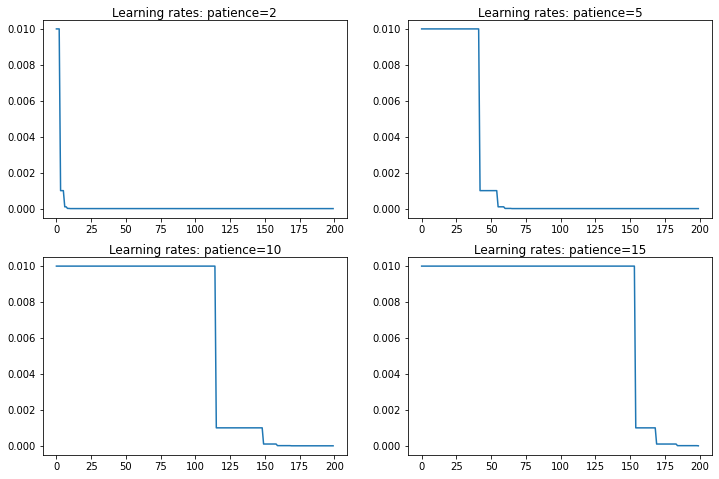

In [40]:
# plot learning rates
line_plots(patiences, lr_list, 'Learning rates')

The first figure shows line plots of the learning rate over the training epochs for each of the evaluated patience values. We can see that the smallest patience value of two rapidly drops the learning rate to a minimum value within 25 epochs, the largest patience of 15 only suffers one drop in the learning rate.

From these plots, **we would expect the patience values of 5 and 10 for this model on this problem to result in better performance as they allow the larger learning rate to be used for some time before dropping the rate to refine the weights.**

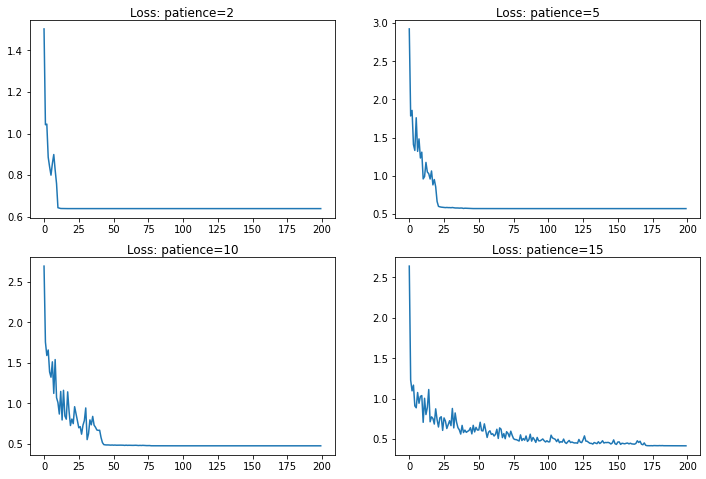

In [36]:
# plot loss
line_plots(patiences, loss_list, 'Loss')

The above figure shows the loss on the training dataset for each of the patience values.

The plot shows that the patience values of 2 and 5 result in a rapid convergence of the model, perhaps to a sub-optimal loss value. In the case of a patience level of 10 and 15, loss drops reasonably until the learning rate is dropped below a level that large changes to the loss can be seen. This occurs halfway for the patience of 10 and nearly the end of the run for patience 15.

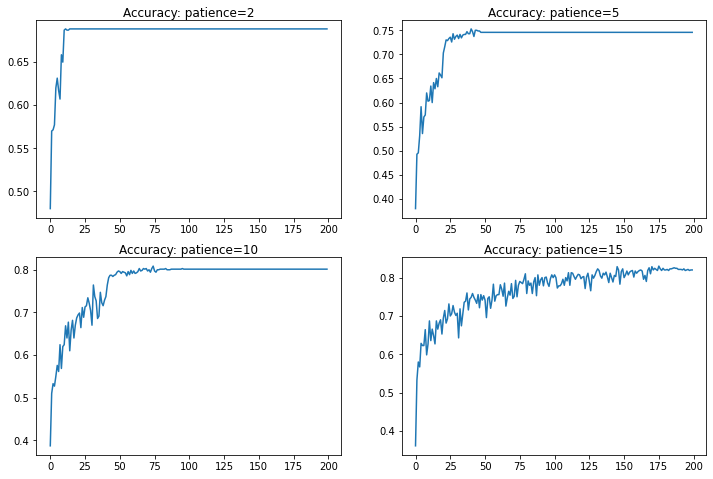

In [37]:
# plot accuracy
line_plots(patiences, acc_list, 'Accuracy')

The final figure shows the training set accuracy over training epochs for each patience value.

<b><font color='darkred'>We can see that indeed the small patience values of 2 and 5 epochs results in premature convergence of the model to a less-than-optimal model at around 65% and less than 75% accuracy respectively</font></b>. The larger patience values result in better performing models, with the patience of 10 showing convergence just before 150 epochs, whereas the patience 15 continues to show the effects of a volatile accuracy given the nearly completely unchanged learning rate.

These plots show how a learning rate that is decreased a sensible way for the problem and chosen model configuration can result in both a skillful and converged stable set of final weights, a desirable property in a final model at the end of a training run.

<a id='sect6'></a>
## <font color='darkblue'>Effect of Adaptive Learning Rates</font> ([back](#sect0))
<font size='3ptx'><b>Learning rates and learning rate schedules are both challenging to configure and critical to the performance of a deep learning neural network model.</b></font>

Keras provides a number of different popular variations of stochastic gradient descent with adaptive learning rates, such as:
* Adaptive Gradient Algorithm ([**AdaGrad**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad)).
* Root Mean Square Propagation ([**RMSprop**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop)).
* Adaptive Moment Estimation ([**Adam**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)).
<br/>

Each provides a different methodology for adapting learning rates for each weight in the network.

**There is no single best algorithm, and the results of racing optimization algorithms on one problem are unlikely to be transferable to new problems.**

We can study the dynamics of different adaptive learning rate methods on the blobs problem. The <font color='blue'>fit_model()</font> function can be updated to take the name of an optimization algorithm to evaluate, which can be specified to the “<font color='violet'>optimizer</font>” argument when the MLP model is compiled. The default parameters for each method will then be used. The updated version of the function is listed below.

In [41]:
# fit a model and plot learning curve
def fit_model(trainX, trainy, testX, testy, optimizer):
    # define model
    model = Sequential()
    model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=200, verbose=0)
    
    # plot learning curves
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    pyplot.title('opt='+optimizer, pad=-80)

We can explore the three popular methods of [**RMSprop**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop), [**AdaGrad**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad) and [**Adam**](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) and compare their behavior to simple stochastic gradient descent with a static learning rate.

We would **expect the adaptive learning rate versions of the algorithm to perform similarly or better, perhaps adapting to the problem in fewer training epochs, but importantly, to result in a more stable model**.

Running the example creates a single figure that contains four line plots for the different evaluated optimization algorithms. Classification accuracy on the training dataset is marked in blue, whereas accuracy on the test dataset is marked in orange:

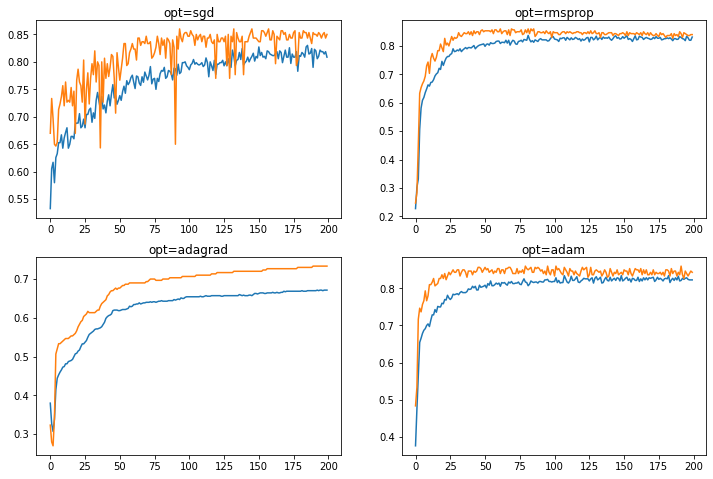

In [43]:
pyplot.rcParams['figure.figsize'] = [12, 8]

# prepare dataset
trainX, trainy, testX, testy = prepare_data(1000)

# create learning curves for different optimizers
momentums = ['sgd', 'rmsprop', 'adagrad', 'adam']
for i in range(len(momentums)):
    # determine the plot number
    plot_no = 220 + (i+1)
    pyplot.subplot(plot_no)
    # fit model and plot learning curves for an optimizer
    fit_model(trainX, trainy, testX, testy, momentums[i])

# show learning curves
pyplot.show()

Again, we can see that SGD with a default learning rate of 0.01 and no momentum does learn the problem, but requires nearly all 200 epochs and results in volatile accuracy on the training data and much more so on the test dataset. **The plots show that all three adaptive learning rate methods learning the problem faster and <font color='green'>with dramatically less volatility between train and test set accuracy</font>.**

## <font color='darkblue'>Further Reading</font>
This section provides more resources on the topic if you are looking to go deeper.

* **Posts**
    * [How to Configure the Learning Rate Hyperparameter When Training Deep Learning Neural Networks](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/)
* **Papers**
    * [Practical recommendations for gradient-based training of deep architectures, 2012.](https://arxiv.org/abs/1206.5533)
* **Books**
    * [Chapter 8: Optimization for Training Deep Models, Deep Learning, 2016.](https://amzn.to/2NJW3gE)
    * [Chapter 6: Learning Rate and Momentum, Neural Smithing: Supervised Learning in Feedforward Artificial Neural Networks, 1999.](https://amzn.to/2S8qRdI)
    * [Section 5.7: Gradient descent, Neural Networks for Pattern Recognition, 1995.](https://amzn.to/2S8qdwt)
* **Articles**
    * [Stochastic gradient descent, Wikipedia.](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)
    * [What learning rate should be used for backprop?, Neural Network FAQ.](ftp://ftp.sas.com/pub/neural/FAQ2.html#A_learn_rate)